# Let's learn some optimizers

### Normal Gradient Descent

In [3]:
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    
    def step(self, weights, grads):
        raise NotImplementedError("Subclass must implement step method")

In [27]:

from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

def beale_function(x, y):
    """
    Beale function - a classic optimization test function
    Global minimum: f(3, 0.5) = 0
    """
    term1 = (1.5 - x + x*y)**2
    term2 = (2.25 - x + x*y**2)**2
    term3 = (2.625 - x + x*y**3)**2
    return term1 + term2 + term3

def compute_gradients(x, y):
    """
    Compute gradients of Beale function numerically
    """
    eps = 1e-7
    dx = (beale_function(x + eps, y) - beale_function(x - eps, y)) / (2 * eps)
    dy = (beale_function(x, y + eps) - beale_function(x, y - eps)) / (2 * eps)
    return np.array([dx, dy])


def optimize(optimizer, start_point, n_steps=100):
    current_point = np.array(start_point)
    history = [current_point.copy()]
    function_values = [beale_function(*current_point)]
    distances = []
    
    for _ in range(n_steps):
        grads = compute_gradients(*current_point)
        prev_point = current_point.copy()
        current_point = optimizer.step(current_point, grads)
        
        # Calculate distance moved in this step
        step_distance = np.sqrt(np.sum((current_point - prev_point)**2))
        distances.append(step_distance)
        
        # Store history and function value
        history.append(current_point.copy())
        function_values.append(beale_function(*current_point))
    
    stats = {
        'final_value': function_values[-1],
        'total_distance': sum(distances),
        'avg_step_size': np.mean(distances),
        'min_value': min(function_values),
        'function_values': function_values
    }
    
    return np.array(history), stats

def plot_contour_and_path(histories, names, colors, stats):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Contour plot (left subplot)
    x = np.linspace(-4.5, 4.5, 100)
    y = np.linspace(-4.5, 4.5, 100)
    X, Y = np.meshgrid(x, y)
    Z = beale_function(X, Y)
    
    # Use log norm for the colors
    norm = LogNorm(vmin=Z.min(), vmax=Z.max())
    
    # Create color mesh with log scale
    mesh = ax1.pcolormesh(X, Y, Z, norm=norm, cmap='viridis')
    
    # Add contour lines with log-spaced levels
    contours = ax1.contour(X, Y, Z, 
                        levels=np.logspace(np.log10(max(Z.min(), 1e-1)), np.log10(Z.max()), 30),
                        colors='white', alpha=0.5)
    ax1.clabel(contours, inline=True, fontsize=8)
    
    # Mark global minimum
    ax1.plot(3, 0.5, 'r*', markersize=15, label='Global Minimum (3, 0.5)')
    
    # Plot optimization paths
    for history, name, color, stat in zip(histories, names, colors, stats):
        ax1.plot(history[:, 0], history[:, 1], color=color, 
                label=f'{name}', marker='o', markersize=3)
        
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Optimization Paths')
    ax1.legend()
    ax1.grid(True)
    
    # Add colorbar to the first subplot
    plt.colorbar(mesh, ax=ax1, label='Function Value (log scale)')
    
    # Convergence plot (right subplot)
    for name, color, stat in zip(names, colors, stats):
        ax2.plot(stat['function_values'], color=color, label=name)
    
    ax2.set_yscale('log')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Function Value (log)')
    ax2.set_title('Convergence Plot')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nOptimization Statistics:")
    print("-" * 50)
    for name, stat in zip(names, stats):
        print(f"\n{name}:")
        print(f"Final Value: {stat['final_value']:.6f}")
        print(f"Best Value Found: {stat['min_value']:.6f}")
        print(f"Total Distance Traveled: {stat['total_distance']:.6f}")
        print(f"Average Step Size: {stat['avg_step_size']:.6f}")

### Implementing Gradient Descent

In [60]:
class GradientDescent(Optimizer):
    def step(self, weights, grads):
        return weights - self.learning_rate * grads

class MomentumGradientDescent(Optimizer):
    def __init__(self, learning_rate, momentum):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocity = 0
    def step(self, weights, grads):
        self.velocity = self.momentum * self.velocity - self.learning_rate * grads
        return weights + self.velocity

class NesterovAcceleratedGradient(Optimizer):
    def __init__(self, learning_rate, momentum):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocity = 0
    def step(self, weights, grads):
        self.velocity = self.momentum * self.velocity - self.learning_rate * grads
        return weights + self.momentum * self.velocity - self.learning_rate * grads

class AdaGrad:
    def __init__(self, learning_rate=0.9, epsilon=1e-7):
        self.lr = learning_rate
        self.epsilon = epsilon
        self.G = np.zeros(2)
        
    def step(self, params, grads):
        self.G += grads**2  # Just accumulates, no decay
        adjusted_lr = self.lr / (np.sqrt(self.G) + self.epsilon)
        return params - adjusted_lr * grads

class RMSProp:
    def __init__(self, learning_rate=0.001, decay=0.9, epsilon=1e-7):
        self.lr = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.cache = None  # Initialize as None, will set shape on first update
        
    def step(self, params, grads):
        # Initialize cache with proper shape on first step
        if self.cache is None:
            self.cache = np.zeros_like(params)
            
        # Update moving average of squared gradients
        self.cache = self.decay * self.cache + (1 - self.decay) * grads**2
        
        # Compute adjusted learning rates and update
        adjusted_lr = self.lr / (np.sqrt(self.cache) + self.epsilon)
        return params - adjusted_lr * grads

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0  # Add time step counter for correct bias correction
        
    def step(self, params, grads):
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
            
        self.t += 1  # Increment time step
        
        # Update momentum and velocity
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * grads**2
        
        # Bias correction
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)
        
        return params - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

class AdamW:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7, weight_decay=0.01):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.m = None
        self.v = None
        self.t = 0
        
    def step(self, params, grads):
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
            
        self.t += 1
        
        # Update momentum and velocity
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * grads**2
        
        # Bias correction
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)
        
        # AdamW decouples weight decay from gradient update
        return (1 - self.lr * self.weight_decay) * params - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

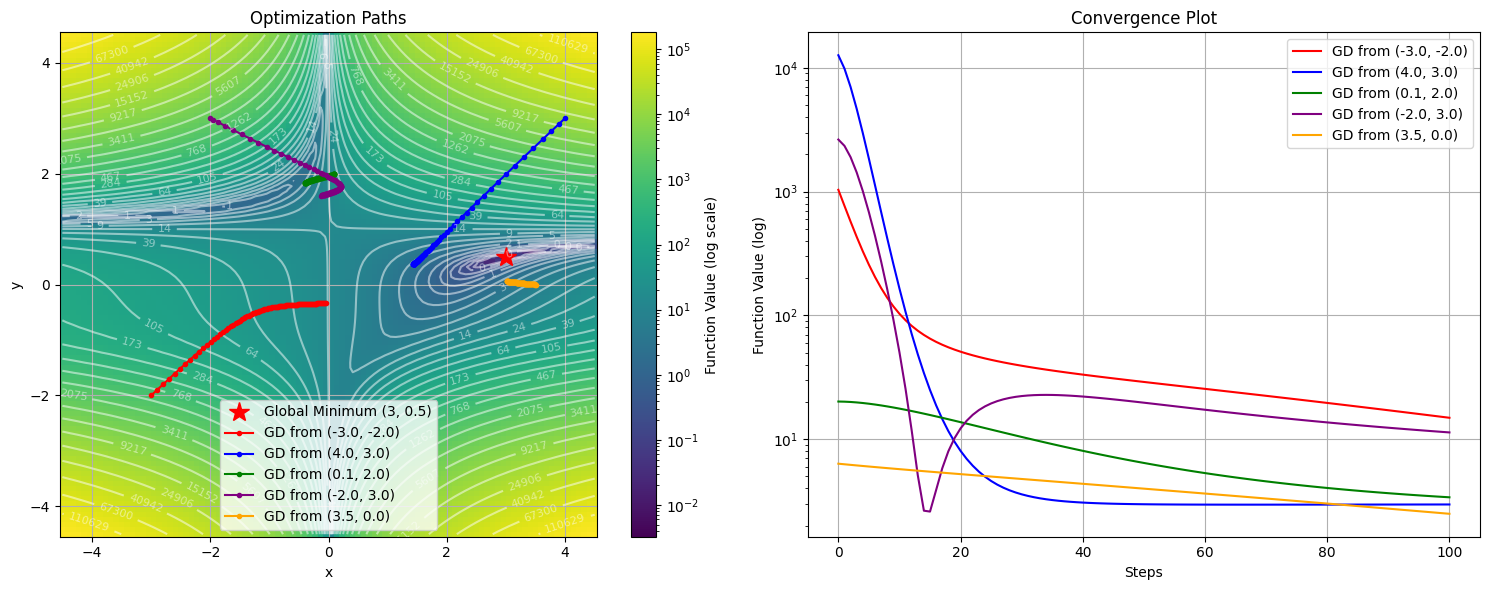


Optimization Statistics:
--------------------------------------------------

GD from (-3.0, -2.0):
Final Value: 14.870235
Best Value Found: 14.870235
Total Distance Traveled: 3.528830
Average Step Size: 0.035288

GD from (4.0, 3.0):
Final Value: 2.963759
Best Value Found: 2.953740
Total Distance Traveled: 3.677817
Average Step Size: 0.036778

GD from (0.1, 2.0):
Final Value: 3.386635
Best Value Found: 3.386635
Total Distance Traveled: 0.534089
Average Step Size: 0.005341

GD from (-2.0, 3.0):
Final Value: 11.322276
Best Value Found: 2.596710
Total Distance Traveled: 2.918896
Average Step Size: 0.029189

GD from (3.5, 0.0):
Final Value: 2.491695
Best Value Found: 2.491695
Total Distance Traveled: 0.494381
Average Step Size: 0.004944


In [69]:
# List of starting points to try
start_points = [
    [-3.0, -2.0],  # Left valley
    [4.0, 3.0],    # Upper right
    [0.1, 2.0],    # Near the cliff
    [-2.0, 3.0],   # Upper left
    [3.5, 0.0],    # Close to minimum
]

# Run gradient descent from each point
histories = []
names = []
colors = ['r', 'b', 'g', 'purple', 'orange']
all_stats = []

optimizer = AdamW(learning_rate=0.1)

for start_point in start_points:
    history, stats = optimize(optimizer, start_point)
    histories.append(history)
    names.append(f'GD from ({start_point[0]}, {start_point[1]})')
    all_stats.append(stats)

plot_contour_and_path(histories, names, colors, all_stats)